# Download OCCA data from [here](http://www.ecco-group.org/products.htm)

In [1]:
import numpy as np
import xarray as xray
import gsw
import os
from scipy import io
from scipy import fftpack as fft
from scipy.optimize import curve_fit

from matplotlib import pyplot as plt
%matplotlib inline

In [295]:
from oceanmodes import baroclinic
reload(baroclinic)

<module 'oceanmodes.baroclinic' from '/home/takaya/oceanmodes/oceanmodes/baroclinic.py'>

In [193]:
basedir = '/data/scratch/takaya/OCCA/annual'
fname_eta_surf = os.path.join(basedir, 'DDetan.0406annclim.nc')
fname_potP_bot = os.path.join(basedir, 'DDphibot.0406annclim.nc')
fname_potP = os.path.join(basedir, 'DDphihyd.0406annclim.nc')  # potentail pressure: P/rho
fname_rhoanom = os.path.join(basedir, 'DDrhoan.0406annclim.nc')
fname_u = os.path.join(basedir, 'DDuvel.0406annclim.nc')
fname_v = os.path.join(basedir, 'DDvvel.0406annclim.nc')
fname_s = os.path.join(basedir, 'DDsalt.0406annclim.nc')
fname_t = os.path.join(basedir, 'DDtheta.0406annclim.nc')

In [194]:
nc_eta_surf = xray.open_dataset(fname_eta_surf)
nc_potP_bot = xray.open_dataset(fname_potP_bot)
nc_potP = xray.open_dataset(fname_potP)
nc_rhoanom = xray.open_dataset(fname_rhoanom)
nc_u = xray.open_dataset(fname_u)
nc_v = xray.open_dataset(fname_v)
nc_s = xray.open_dataset(fname_s)
nc_t = xray.open_dataset(fname_t)

In [197]:
eta_s = nc_eta_surf.etan[0]
potP_b = nc_potP_bot.phibot[0]
potP = nc_potP.phihyd[0]
rho_anom = nc_rhoanom.rhoanoma[0]
u = nc_u.u[0]
v = nc_v.v[0]
sal = nc_s.salt[0]
theta = nc_t.theta[0]
lat_t = nc_s.Latitude_t
lon_t = nc_s.Longitude_t
lat_v = nc_v.Latitude_v
lon_u = nc_u.Longitude_u
z_t = nc_s.Depth_c
z_u = nc_u.Depth_u

# Derive geostrophic velocity

In [224]:
print potP.values[:, 20, 0], potP.values[:, 20, -1]

[ -18.28566933  -18.42925072  -18.56686783  -18.69758797  -18.8199482
  -18.93309021  -19.0370903   -19.13277435  -19.2214489   -19.30424881
  -19.38214302  -19.45638275  -19.5287571   -19.60124207  -19.67517853
  -19.74976158  -19.81965637  -19.87224197  -19.88490105  -19.8229351
  -19.63894081  -19.27416992  -18.66243935  -17.73610878  -16.43343353
  -14.70406342  -12.5130415    -9.8430357    -6.68998671   -3.05775762
    1.05009902    5.6520257    10.82610703   16.75936127   23.78192139
   32.35907364   43.04357147   56.42181015   73.0890274    93.65625763
  118.77246857  149.14060974  185.52250671  228.73904419  279.668396
  339.24563599  408.45767212  488.33166504           nan           nan] [ -18.22412682  -18.36836433  -18.50669861  -18.63830948  -18.76181602
  -18.87623787  -18.98143768  -19.07815361  -19.16767693  -19.25122261
  -19.32982254  -19.40476799  -19.47787857  -19.55117226  -19.62602615
  -19.70166016  -19.77273369  -19.82655525  -19.84037781  -19.77937889
  -19.596

(160,) (360,) (50, 160, 359) (50,)


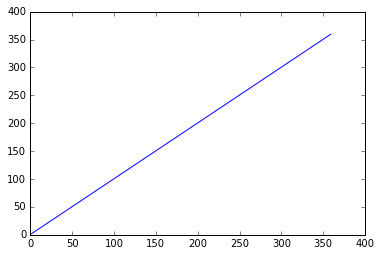

In [226]:
print lat_t.shape, lon_t.shape, potP[:,:,1:].shape, z_t.shape
plt.plot(lon_t)

In [ ]:
# P = gsw.p_from_z(-z_t.values[:, np.newaxis], lat_t.values)
# dx = np.zeros((50, 159, 359))
# dy = np.zeros((50, 159, 359))

# for i in range(359):
#     for j in range(159):
#         for k in range(50):
#             dx[k, j, i] = gsw.earth.distance([lon_t[i], lon_t[i+1]], [lat_t[j], lat_t[j]], [P[k, j], P[k, j]])
#             dy[k, j, i] = gsw.earth.distance([lon_t[i], lon_t[i]], [lat_t[j], lat_t[j+1]], [P[k, j], P[k, j+1]])

In [ ]:
# np.savez('dx_dy_OCCA',
#         dx=dx, dy=dy)

In [214]:
dxdy = np.load('dx_dy_OCCA.npz')
dx = dxdy['dx']
dy = dxdy['dy']

print dx[:, 0, 0]

[ 20263.40133391  20263.3695282   20263.33772249  20263.30591678
  20263.27411108  20263.24230537  20263.21049966  20263.17867803
  20263.14680872  20263.11478037  20263.08229085  20263.04870401
  20263.01282717  20262.97278382  20262.92593397  20262.86890636
  20262.79786829  20262.7088918   20262.59833517  20262.46328816
  20262.30187418  20262.11342536  20261.89860957  20261.65930335
  20261.39841695  20261.11959227  20260.82675689  20260.52374383
  20260.21390878  20259.89982741  20259.58294711  20259.2627589
  20258.93533559  20258.59200864  20258.21962793  20257.80310049
  20257.32914728  20256.78881596  20256.17754145  20255.4936395
  20254.73666362  20253.90653462  20253.00325248  20252.02681721
  20250.97722881  20249.85448728  20248.65859262  20247.38954483
  20246.04734391  20244.63198986]


In [220]:
dx_full = np.zeros((50, 160, 359))
dy_full = np.zeros((50, 159, 360))
dx_full[:, :-1] = dx
dy_full[:, :, :-1] = dy

for k in range(50):
    dx_full[k, -1] = gsw.earth.distance([lon_t[-2], lon_t[-1]], [lat_t[-1], lat_t[-1]], [P[k, -1], P[k, -1]])
    dy_full[k, :, -1] = gsw.earth.distance([lon_t[-1], lon_t[-1]], [lat_t[-2], lat_t[-1]], [P[k, -2], P[k, -1]])

In [254]:
print potP.shape
print (-potP + np.roll(potP, -1, axis=2))[:, :, :-1].shape

(50, 160, 360)
(50, 160, 359)


In [255]:
dPdx = (-potP + np.roll(potP, -1, axis=2))[:, :, :-1]/dx_full
dPdy = (-potP + np.roll(potP, -1, axis=1))[:, :-1]/dy_full

In [6]:
print z_t, z_u

<xarray.DataArray 'Depth_c' (Depth_c: 50)>
array([  5.00000000e+00,   1.50000000e+01,   2.50000000e+01,
         3.50000000e+01,   4.50000000e+01,   5.50000000e+01,
         6.50000000e+01,   7.50050049e+01,   8.50250015e+01,
         9.50950012e+01,   1.05309998e+02,   1.15870003e+02,
         1.27150002e+02,   1.39739990e+02,   1.54470001e+02,
         1.72399994e+02,   1.94735001e+02,   2.22710007e+02,
         2.57470001e+02,   2.99929993e+02,   3.50679993e+02,
         4.09929993e+02,   4.77470001e+02,   5.52710022e+02,
         6.34735046e+02,   7.22400024e+02,   8.14470093e+02,
         9.09740112e+02,   1.00715503e+03,   1.10590503e+03,
         1.20553503e+03,   1.30620508e+03,   1.40914990e+03,
         1.51709497e+03,   1.63417480e+03,   1.76513477e+03,
         1.91414990e+03,   2.08403491e+03,   2.27622510e+03,
         2.49125000e+03,   2.72925000e+03,   2.99025000e+03,
         3.27425000e+03,   3.58125000e+03,   3.91125000e+03,
         4.26425000e+03,   4.64025000e+03,

In [5]:
print lat_t, lat_v
print lon_t, lon_u

<xarray.DataArray 'Latitude_t' (Latitude_t: 160)>
array([-79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5,
       -70.5, -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5,
       -61.5, -60.5, -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5,
       -52.5, -51.5, -50.5, -49.5, -48.5, -47.5, -46.5, -45.5, -44.5,
       -43.5, -42.5, -41.5, -40.5, -39.5, -38.5, -37.5, -36.5, -35.5,
       -34.5, -33.5, -32.5, -31.5, -30.5, -29.5, -28.5, -27.5, -26.5,
       -25.5, -24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18.5, -17.5,
       -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,  -9.5,  -8.5,
        -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,   0.5,
         1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
        10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,  18.5,
        19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,  27.5,
        28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,  36.5,
        37.5,  38.5,  39.5,  40.5,  41.5

In [6]:
print eta_s.shape, sal.shape, z_t.shape, lat_t.shape, lon_t.shape
print v.shape

(160, 360) (50, 160, 360) (50,) (160,) (360,)
(50, 160, 360)


In [7]:
p_t = gsw.p_from_z(-z_t.values[:, np.newaxis], lat_t.values[np.newaxis, :])
absS = gsw.SA_from_SP(sal.values, p_t[:, :, np.newaxis], 
                      lon_t.values[np.newaxis, np.newaxis, :], lat_t.values[np.newaxis, :, np.newaxis])
consT = gsw.CT_from_pt(absS, theta.values)

In [8]:
print absS.shape, consT.shape
# print p_t, absS

(50, 160, 360) (50, 160, 360)


In [9]:
potrho = gsw.rho(absS, consT, 0.)
N2, p_N2 = gsw.Nsquared(absS, consT, 
                        p_t[:, :, np.newaxis], lat_t.values[np.newaxis, :, np.newaxis])

In [10]:
z_N2 = gsw.z_from_p(p_N2, lat_t.values[np.newaxis, :, np.newaxis])

In [11]:
f0 = gsw.earth.f(lat_t.values)
beta = 2.*gsw.earth.OMEGA/gsw.earth.earth_radius * np.cos(np.pi/180.*lat_t.values)

In [247]:
fy = .5 * (f0 + np.roll(f0, -1, axis=0))[:-1]

## $u_g = - \frac{1}{f_0} \frac{\partial \phi}{\partial y}, \ \ v_g = \frac{1}{f_0} \frac{\partial \phi}{\partial x}$

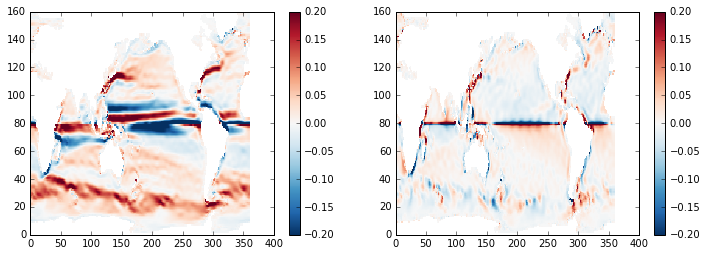

In [256]:
Ug = - dPdy / fy[np.newaxis, :, np.newaxis]
Vg = dPdx / f0[np.newaxis, :, np.newaxis]

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
cax1 = ax1.pcolormesh(np.ma.masked_invalid(Ug[0]), 
                      vmin=-.2, vmax=.2, cmap='RdBu_r')
fig.colorbar(cax1)
ax2 = fig.add_subplot(122)
cax2 = ax2.pcolormesh(np.ma.masked_invalid(Vg[0]), 
                      vmin=-.2, vmax=.2, cmap='RdBu_r')
fig.colorbar(cax2)

# Add metadata

In [269]:
maskUg = np.isnan(Ug.values)
maskVg = np.isnan(Vg.values)
maskT = np.isnan(theta.values)

Ug.values[maskUg] = 0.
Vg.values[maskVg] = 0.

Vg_coinT = xray.DataArray(.5 * (Vg + np.roll(Vg, -1, axis=2))[:, :, :-1], 
                          coords=[('Depth_c', z_u.coords['Depth_u']), 
                                     ('Latitude_t',theta.coords['Latitude_t']), ('Longitude_Vg', theta.coords['Longitude_t'][1:-1])], 
                         dims=['Depth_c', 'Latitude_t', 'Longitude_Vg']).where(~maskT[:, :, 1:-1])
Ug_coinT = xray.DataArray(.5 * (Ug + np.roll(Ug, -1, axis=1))[:, :-1], coords=[('Depth_c', z_u.coords['Depth_u']), 
                                     ('Latitude_Ug',theta.coords['Latitude_t'][1:-1]), ('Longitude_t', theta.coords['Longitude_t'])], 
                         dims=['Depth_c', 'Latitude_Ug', 'Longitude_t']).where(~maskT[:, 1:-1])

In [12]:
absS_meta = xray.DataArray(absS, coords=theta.coords, dims=theta.dims)
consT_meta = xray.DataArray(consT, coords=theta.coords, dims=theta.dims)
potrho_meta = xray.DataArray(potrho, coords=theta.coords, dims=theta.dims)
f0_meta = xray.DataArray(f0, coords=lat_t.coords, dims=lat_t.dims)
beta_meta = xray.DataArray(beta, coords=lat_t.coords, dims=lat_t.dims)

In [13]:
N2_meta = xray.DataArray(N2, coords=[('Depth_N2', z_u.coords['Depth_u'][1:]), 
                                     ('Latitude_t',theta.coords['Latitude_t']), ('Longitude_t', theta.coords['Longitude_t'])], 
                         dims=['Depth_N2', 'Latitude_t', 'Longitude_t'])
zN2_meta = xray.DataArray(z_N2, coords=[('Depth_N2', z_u.coords['Depth_u'][1:]), 
                                     ('Latitude_t',theta.coords['Latitude_t']), ('Longitude_t', theta.coords['Longitude_t'])], 
                         dims=['Depth_N2', 'Latitude_t', 'Longitude_t'])

In [154]:
print theta.coords['Longitude_t'].shape, theta.dims, N2.shape
print z_u.coords, z_u.dims

(360,) (u'Depth_c', u'Latitude_t', u'Longitude_t') (49, 160, 360)
Coordinates:
  * Depth_u  (Depth_u) float32 0.0 10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.01 ... (u'Depth_u',)


# Rigid lid & flat ocean

<xarray.DataArray 'Longitude_u' (Longitude_u: 20)>
array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.], dtype=float32)
Coordinates:
  * Longitude_u  (Longitude_u) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 ...
Attributes:
    long_name: Longitude on U grid                                                     
    units: degree          
    modulo: 360 <xarray.DataArray 'Longitude_t' (Longitude_t: 20)>
array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
         9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
        18.5,  19.5], dtype=float32)
Coordinates:
  * Longitude_t  (Longitude_t) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 ...
Attributes:
    long_name: Longitude on T grid                                                     
    standard_name: longitude
    units: degree_east     
    point_spacing: even
    modulo:  
<xarray.DataArray 'Latitude_v' (Latitude_v: 20)>

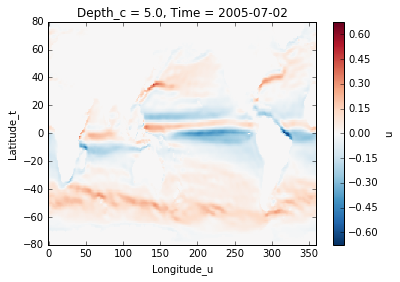

In [53]:
print lon_u[:20], lon_t[:20]
print lat_v[:20], lat_t[:20]
xray.plot.imshow((.5*(u.roll(Longitude_u=-1) + u))[0])

In [14]:
maskU = np.isnan(u.values)
maskV = np.isnan(v.values)

u.values[maskU] = 0.
v.values[maskV] = 0.

In [24]:
print u[:100, :100], v[:100, :100]

<xarray.DataArray 'u' (Depth_c: 50, Latitude_t: 100, Longitude_u: 360)>
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ..., 
       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.

In [15]:
u_coinT = xray.DataArray((.5*(u.roll(Longitude_u=-1).values + u.values)),
                      coords=theta.coords, dims=theta.dims).where(~maskT)
v_coinT = xray.DataArray((.5*(v.roll(Latitude_v=-1).values + v.values)),
                      coords=theta.coords, dims=theta.dims).where(~maskT)
# print u, u_coinT

## Gulf Stream

In [28]:
print u.sel(Longitude_u=GS[0]-.5, Latitude_t=GS[1]), u.sel(Longitude_u=GS[0]+.5, Latitude_t=GS[1])
print v.sel(Longitude_t=GS[0], Latitude_v=GS[1]-.5), v.sel(Longitude_t=GS[0], Latitude_v=GS[1]+.5)

<xarray.DataArray 'u' (Depth_c: 50)>
array([ 0.23944686,  0.202685  ,  0.18200348,  0.17409228,  0.16885349,
        0.16435893,  0.16032954,  0.15664397,  0.15308236,  0.14954343,
        0.14679012,  0.14432698,  0.1414368 ,  0.13848211,  0.13460122,
        0.13018939,  0.1244467 ,  0.11745287,  0.10890713,  0.09883665,
        0.08717503,  0.07444824,  0.06123254,  0.04839063,  0.03677421,
        0.0268672 ,  0.01867473,  0.0121845 ,  0.00760518,  0.00489767,
        0.00353413,  0.00285542,  0.0024165 ,  0.00199221,  0.00144401,
        0.0006767 , -0.00030298, -0.00136913, -0.00236471, -0.00318346,
       -0.00376874, -0.00404952, -0.00395442, -0.00351102, -0.00283759,
       -0.00198498, -0.00068925,  0.00059345,  0.        ,  0.        ])
Coordinates:
    Longitude_u  float32 299.0
    Latitude_t   float32 39.5
  * Depth_c      (Depth_c) float32 5.0 15.0 25.0 35.0 45.0 55.0 65.0 75.005 ...
    Time         datetime64[ns] 2005-07-02
Attributes:
    long_name: Zonal Velocity    

In [270]:
GS = np.array([299.5, 39.5])
u_GS = Ug_coinT.sel(Longitude_t=GS[0], Latitude_Ug=GS[1])
v_GS = Vg_coinT.sel(Longitude_Vg=GS[0], Latitude_t=GS[1])

In [17]:
absS_GS = absS_meta.sel(Longitude_t=GS[0], Latitude_t=GS[1])
consT_GS = consT_meta.sel(Longitude_t=GS[0], Latitude_t=GS[1])
rho_GS = rho_anom.sel(Longitude_t=GS[0], Latitude_t=GS[1])
potrho_GS = potrho_meta.sel(Longitude_t=GS[0], Latitude_t=GS[1])

In [18]:
N2_GS = N2_meta.sel(Longitude_t=GS[0], Latitude_t=GS[1])
zN2_GS = zN2_meta.sel(Longitude_t=GS[0], Latitude_t=GS[1])

In [32]:
print absS_GS, consT_GS, N2_GS
print u_GS, v_GS

<xarray.DataArray (Depth_c: 50)>
array([ 36.37705617,  36.38829268,  36.43808331,  36.49948204,
        36.53953381,  36.55776704,  36.56630143,  36.57135183,
        36.57744907,  36.57823244,  36.57765099,  36.57286845,
        36.56452534,  36.55226472,  36.53229802,  36.50537004,
        36.46777153,  36.41438766,  36.34106086,  36.24866002,
        36.1329151 ,  35.98797394,  35.82308989,  35.66429781,
        35.51827826,  35.39446247,  35.29708428,  35.22529779,
        35.17724572,  35.15076161,  35.14115192,  35.14007741,
        35.13925532,  35.13451384,  35.12538326,  35.11673309,
        35.11542681,  35.12178446,  35.12816684,  35.12755937,
        35.12004502,  35.11000069,  35.10029747,  35.09019658,
        35.0800635 ,  35.07483442,  35.07510403,  35.07778868,
                nan,          nan])
Coordinates:
    Longitude_t  float32 299.5
    Latitude_t   float32 39.5
  * Depth_c      (Depth_c) float32 5.0 15.0 25.0 35.0 45.0 55.0 65.0 75.005 ...
    Time         date

In [265]:
def model_func(x, A, K, C):
    return A * np.exp(K * x) + C

def fit_exp_linear(x, y, C=0):
    """fit an exponential"""
    y = y - C
    y = np.log(y)
    K, A_log = np.polyfit(x, y, 1)
    A = np.exp(A_log)
    return A, K

In [266]:
u0 = u_GS.values[-3]; v0 = v_GS.values[-3]; N20 = N2_GS.values[-3]

# u_raw = u_GS.values.copy()
# v_raw = v_GS.values.copy()
# u_raw[u_raw<0.] = 1e-3
# v_raw[v_raw<0.] = 1e-3

A, K = fit_exp_linear(z_t.values[:-3], u_GS.values[:-3], C=-5e-3)
u_fit = model_func(z_t.values, A, K, -5e-3)
A, K = fit_exp_linear(z_t.values[:-3], v_GS.values[:-3], C=-5e-3)
v_fit = model_func(z_t.values, A, K, -5e-3)
A, K = fit_exp_linear(-zN2_GS.values[:-3], N2_GS.values[:-3], C=N20)
N2_fit = model_func(-zN2_GS.values, A, K, N20)

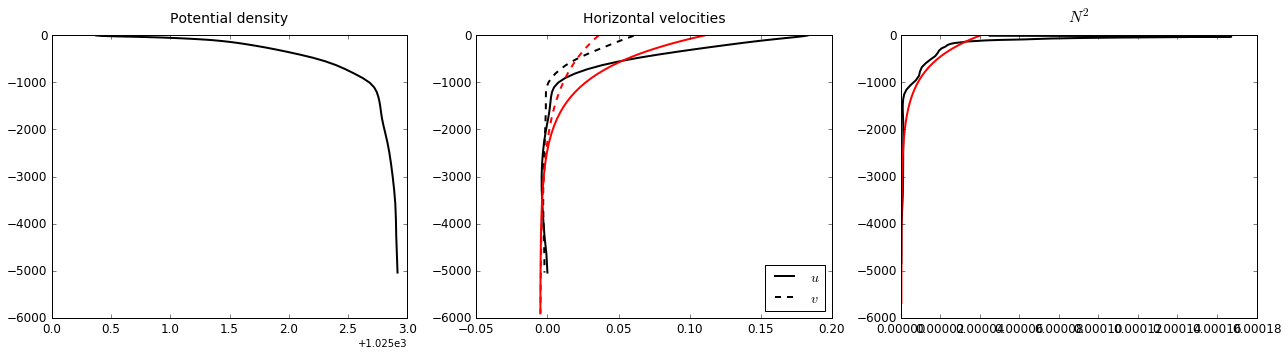

In [271]:
fig = plt.figure(figsize=(18,5))

ax1 = fig.add_subplot(131)
ax1.plot(potrho_GS.values, -z_t.values, 'k', lw=2)
ax1.set_title('Potential density', fontsize=14, y=1.03)
# ax1.set_xlabel('lon', fontsize=12)
# ax1.set_ylabel('lat', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax2 = fig.add_subplot(132)
ax2.plot(u_GS.values, -z_t.values, 'k', lw=2, label=r'$u$')
ax2.plot(v_GS.values, -z_t.values, 'k--', lw=2, label=r'$v$')
ax2.plot(u_fit, -z_t.values, 'r', lw=2)
ax2.plot(v_fit, -z_t.values, 'r--', lw=2)
ax2.set_title('Horizontal velocities', fontsize=14, y=1.03)
# ax2.set_xlabel('lon', fontsize=12)
# ax2.set_ylabel('lat',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=14)

ax3 = fig.add_subplot(133)
ax3.plot(N2_GS.values, zN2_GS.values, 'k', lw=2)
ax3.plot(N2_fit, zN2_GS.values, 'r', lw=2)
ax3.set_title(r'$N^2$', fontsize=16, y=1.03)
# ax1.set_xlabel('lon', fontsize=12)
# ax1.set_ylabel('lat', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

In [20]:
zphi_GS, Rd_GS, vd_GS = baroclinic.neutral_modes_from_N2_profile(-zN2_GS.values, 
                                                        N2_GS.values, f0_meta.sel(Latitude_t=GS[1]).values)

In [21]:
np.savez('OCCA_global',
        absolute_salinity=absS, conservative_temperature=consT,
        potential_density=potrho_meta, 
        z_N2=zN2_meta, N2=N2_meta,
        u_at_Tpoints=u_coinT, v_at_Tpoints=v_coinT,
        z_u=z_t
        )

[            nan  25787.38588424  13900.4970779    9608.06511652
   6906.66296569   5876.40199714] (48,) [-0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757
 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757
 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757
 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757
 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757
 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757
 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757
 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757 -0.14433757] [-0.2287108  -0.22844163 -0.22738221 -0.22538205 -0.22315635 -0.22100572
 -0.21890111 -0.21681132 -0.21466035 -0.21249153 -0.21051281 -0.20857709
 -0.20653185 -0.20436013 -0.20172795 -0.19864415 -0.19475028 -0.18960952
 -0.18268901 -0.17391394 -0.16270843 -0.14845062 -0.13133273 -0.11305419
 -0.09473064 -0.07

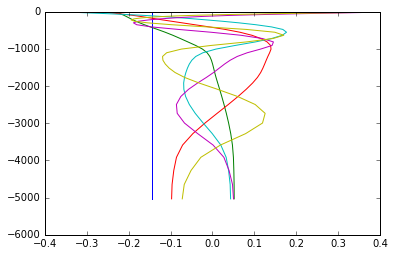

In [22]:
print Rd_GS, zphi_GS.shape, vd_GS[:, 0], vd_GS[:, 1]
plt.figure()
for i in range(vd_GS.shape[1]):
    plt.plot(vd_GS[:, i], -zphi_GS)

In [23]:
np.savez('OCCA_GulfStream',
        absolute_salinity=absS_GS.values, conservative_temperature=consT_GS.values,
        potential_density=potrho_GS.values, 
        z_N2=zN2_GS.values, N2=N2_GS.values,
        u_at_Tpoints=u_GS.values, v_at_Tpoints=v_GS.values, z_u=z_t.values,
        f0=f0_meta.sel(Latitude_t=GS[1]).values, beta=beta_meta.sel(Latitude_t=GS[1]).values,
        Rossby_radii=Rd_GS
        )

In [76]:
print N2_GS

<xarray.DataArray (Depth_c: 49)>
array([  4.49013733e-05,   1.32619531e-04,   1.67213349e-04,
         1.39980381e-04,   1.08620176e-04,   8.89353316e-05,
         7.59696940e-05,   6.85660114e-05,   6.13053056e-05,
         4.96623307e-05,   4.26153730e-05,   3.83933836e-05,
         3.33244718e-05,   3.14573673e-05,   2.74780120e-05,
         2.50869570e-05,   2.35907064e-05,   2.26047540e-05,
         2.06309696e-05,   1.93499569e-05,   1.85802260e-05,
         1.73887368e-05,   1.49995125e-05,   1.25945779e-05,
         1.06210281e-05,   9.69791903e-06,   9.18845407e-06,
         7.56655382e-06,   5.00383224e-06,   2.83633215e-06,
         1.67170878e-06,   1.19350982e-06,   9.87252978e-07,
         9.54096555e-07,   1.05979705e-06,   1.18957478e-06,
         1.23432375e-06,   1.22190029e-06,   1.20084648e-06,
         1.18287498e-06,   1.14801849e-06,   1.08643614e-06,
         9.36511867e-07,   6.17342678e-07,   3.35507108e-07,
         3.19646379e-07,   2.60733349e-07,          

In [155]:
dx_GS = gsw.earth.distance([GS[0]-.5,GS[0]+.5], [GS[1],GS[1]])[0][0]
dy_GS = gsw.earth.distance([GS[0],GS[0]], [GS[1]-.5,GS[1]+.5])[0][0]
dx = 4e3; dy = 4e3
Nx_GS = 100
Ny_GS = 100
k = 2*np.pi*fft.fftshift( fft.fftfreq(Nx_GS, dx_GS/20) )
l = 2*np.pi*fft.fftshift( fft.fftfreq(Ny_GS, dx_GS/20) )

k_GS = k[np.absolute(k) < 5.*Rd_GS[1]**-1]
l_GS = l[np.absolute(l) < 5.*Rd_GS[1]**-1]

In [150]:
print dx_GS, dy_GS
print (2*dx_GS)**-1, 5.*Rd_GS[1]**-1, (Nx_GS*dx_GS)**-1
print k_GS.shape, l_GS.shape, k.shape

85800.2983284 111194.926645
5.82748556522e-06 0.000193893247747 1.16549711304e-07
(100,) (100,) (100,)


In [100]:
print u_GS.shape, v_GS.shape, dx_GS, dy_GS, zN2_GS.shape
print zN2_GS, z_t

(50,) (50,) 85800.2983284 111194.926645 (49,)
<xarray.DataArray (Depth_c: 49)>
array([  -10.00006115,   -20.00006114,   -30.00006113,   -40.00006112,
         -50.0000611 ,   -60.00006109,   -70.00256358,   -80.01506451,
         -90.06006328,  -100.20256308,  -110.5900682 ,  -121.51007976,
        -133.44509256,  -147.10512803,  -163.43519352,  -183.5678012 ,
        -208.72298023,  -240.09073926,  -278.70109317,  -325.30655719,
        -380.30712264,  -443.70276088,  -515.09343642,  -593.72659767,
        -678.57216844,  -768.44015906,  -862.11055267,  -958.45325725,
       -1056.53586028, -1155.72595435, -1255.87608991, -1357.68378579,
       -1463.12934261, -1575.64299213, -1699.66489761, -1839.65538686,
       -1999.10931291, -2180.15155508, -2383.76440293, -2610.28273438,
       -2859.78914881, -3132.29607118, -3427.80347989, -3746.3113517 ,
       -4087.81966191, -4452.32838443, -4839.83749199, -5250.34695635,
       -5683.85674858])
Coordinates:
    Longitude_t  float32 299.5
 

In [26]:
etax = np.zeros(2)
etay = np.zeros(2)

print f0_meta.sel(Latitude_t=GS[1]).values
print beta_meta.sel(Latitude_t=GS[1]).values
# kwargs = {'v0':np.ones(len(zN2_GS)+1), 'num_Lanczos':int(1e10), 'iteration':int(1e7), 'tol':1e-5}

9.27671062527e-05
1.76637107718e-11


### Exponential profiles

#### w/out lateral viscosity

In [306]:
zpsi_GSx0, w_GSx0, psi_GSx0 = baroclinic.instability_analysis_from_N2_profile( -zN2_GS.values, 
                                                                   N2_fit, f0_meta.sel(Latitude_t=GS[1]).values,
                                                                   beta_meta.sel(Latitude_t=GS[1]).values,
                                                                   k_GS, l_GS, z_t.values, u_fit, v_fit, etax, etay,
                                                                   Ah=0., num=2 )

In [307]:
print w_GSx0[0].shape, np.argmax(w_GSx0.imag[0]), psi_GSx0[:, 0].shape
# print (np.absolute(psi_GSx0[:, 1])**2).sum(axis=0)

(27, 27) 392 (50, 27, 27)


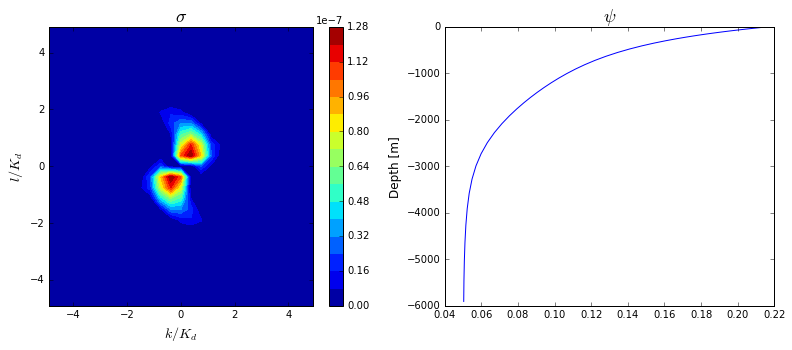

In [308]:
fig = plt.figure(figsize=(13,5))

ax1 = fig.add_subplot(121)
cax = ax1.contourf(k_GS*Rd_GS[1], l_GS*Rd_GS[1], w_GSx0.imag[0], 20)
cbar = fig.colorbar(cax, orientation='vertical')
ax1.set_xlabel(r'$k/K_d$', fontsize=14)
ax1.set_ylabel(r'$l/K_d$', fontsize=14)
ax1.set_title(r'$\sigma$', fontsize=18)

ax2 = fig.add_subplot(122)
ax2.plot(np.reshape(np.absolute(psi_GSx0[:, 0]), 
                    (len(zpsi_GSx0), psi_GSx0.shape[-1]**2))[:, np.argmax(w_GSx0.imag[0])], -zpsi_GSx0)
# ax2.plot(psi[:, 1, 19], -zpsi)
ax2.set_ylabel(r'Depth [m]', fontsize=12)
ax2.set_title(r'$\psi$', fontsize=18)

#### w/ lateral viscosity

In [309]:
zpsi_GSx10, w_GSx10, psi_GSx10 = baroclinic.instability_analysis_from_N2_profile( -zN2_GS.values, 
                                                                   N2_fit, f0_meta.sel(Latitude_t=GS[1]).values,
                                                                   beta_meta.sel(Latitude_t=GS[1]).values,
                                                                   k_GS, l_GS, z_t.values, u_fit, v_fit, etax, etay,
                                                                   Ah=1e1, num=2 )

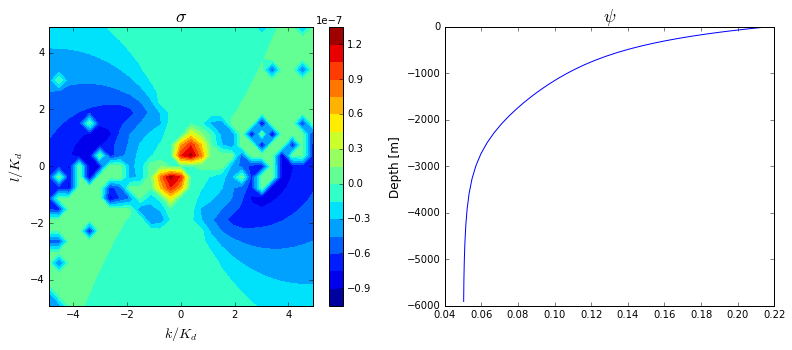

In [310]:
fig = plt.figure(figsize=(13,5))

ax1 = fig.add_subplot(121)
cax = ax1.contourf(k_GS*Rd_GS[1], l_GS*Rd_GS[1], w_GSx10.imag[0], 20)
cbar = fig.colorbar(cax, orientation='vertical')
ax1.set_xlabel(r'$k/K_d$', fontsize=14)
ax1.set_ylabel(r'$l/K_d$', fontsize=14)
ax1.set_title(r'$\sigma$', fontsize=18)

ax2 = fig.add_subplot(122)
ax2.plot(np.reshape(np.absolute(psi_GSx10[:, 0]), 
                    (len(zpsi_GSx10), psi_GSx10.shape[-1]**2))[:, np.argmax(w_GSx10.imag[0])], -zpsi_GSx10)
ax2.set_ylabel(r'Depth [m]', fontsize=12)
ax2.set_title(r'$\psi$', fontsize=18)

### Actual profile
#### w/out lateral viscosity ($A_h=0$)

In [311]:
zpsi_GS0, w_GS0, psi_GS0 = baroclinic.instability_analysis_from_N2_profile( -zN2_GS.values, 
                                                                   N2_GS.values, f0_meta.sel(Latitude_t=GS[1]).values,
                                                                   beta_meta.sel(Latitude_t=GS[1]).values,
                                                                   k_GS, l_GS, z_t.values, u_GS.values, v_GS.values, etax, etay,
                                                                   Ah=0., num=2 )

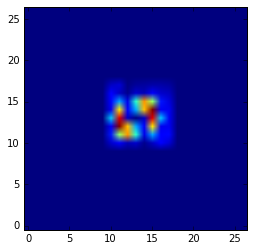

In [312]:
sig = w_GS0[0].copy()
for i in range(10):
    sig[:, i] = np.nan
for j in range(10):
    sig[j, :] = np.nan

for i in range(-1,-10,-1):
    sig[:, i] = np.nan
for j in range(-1,-10,-1):
    sig[j, :] = np.nan

plt.imshow(sig.imag, origin='bottom')

In [313]:
print psi_GS0.shape, len(zpsi_GS0)

(48, 2, 27, 27) 48


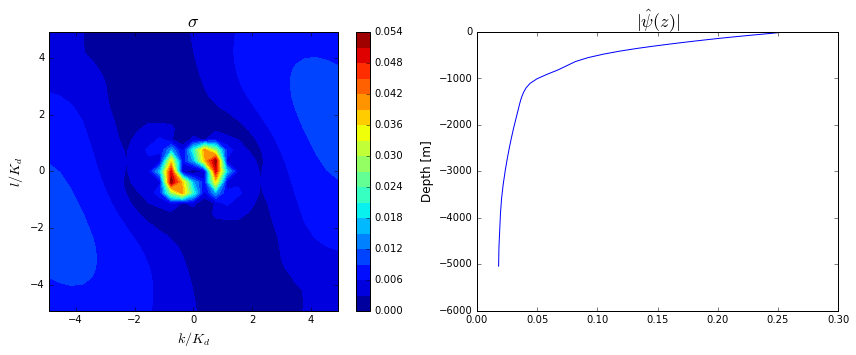

In [314]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121)
cax = ax1.contourf(k_GS*Rd_GS[1], l_GS*Rd_GS[1], w_GS0.imag[0]*24*3600., 20)
cbar = fig.colorbar(cax, orientation='vertical')
ax1.set_xlabel(r'$k/K_d$', fontsize=14)
ax1.set_ylabel(r'$l/K_d$', fontsize=14)
ax1.set_title(r'$\sigma$', fontsize=18)

ax2 = fig.add_subplot(122)
ax2.plot(np.reshape(np.absolute(psi_GS0[:, 0]), (len(zpsi_GS0), 
                                psi_GS0.shape[-1]**2))[:, np.nanargmax(w_GS0.imag[0])], -zpsi_GS0)
ax2.set_ylabel(r'Depth [m]', fontsize=12)
ax2.set_title(r'$|\hat{\psi}(z)|$', fontsize=18)

plt.tight_layout()

#### w/ lateral viscosity ($A_h=10$)

In [315]:
zpsi_GS10, w_GS10, psi_GS10 = baroclinic.instability_analysis_from_N2_profile( -zN2_GS.values, 
                                                                   N2_GS.values, f0_meta.sel(Latitude_t=GS[1]).values,
                                                                   beta_meta.sel(Latitude_t=GS[1]).values,
                                                                   k_GS, l_GS, z_t.values, u_GS.values, v_GS.values, etax, etay,
                                                                   Ah=1e1, num=2 )

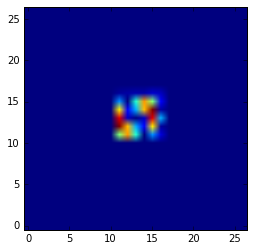

In [316]:
sig = w_GS10[0].copy()
for i in range(11):
    sig[:, i] = np.nan
for j in range(11):
    sig[j, :] = np.nan

for i in range(-1,-11,-1):
    sig[:, i] = np.nan
for j in range(-1,-11,-1):
    sig[j, :] = np.nan

plt.imshow(sig.imag, origin='bottom')

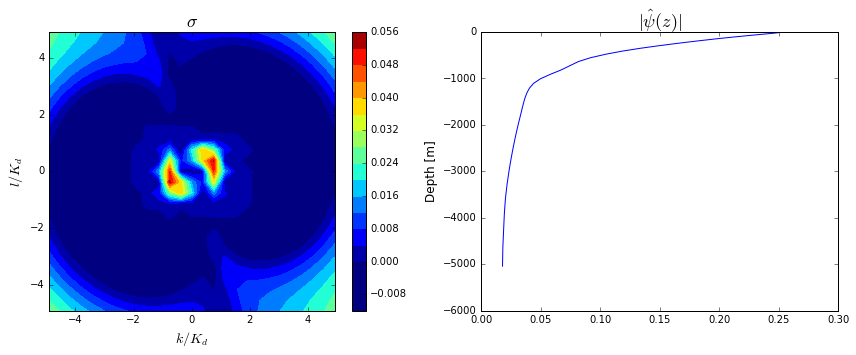

In [317]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121)
cax = ax1.contourf(k_GS*Rd_GS[1], l_GS*Rd_GS[1], w_GS10.imag[0]*24*3600., 20, vmin=0.)
cbar = fig.colorbar(cax, orientation='vertical')
ax1.set_xlabel(r'$k/K_d$', fontsize=14)
ax1.set_ylabel(r'$l/K_d$', fontsize=14)
ax1.set_title(r'$\sigma$', fontsize=18)

ax2 = fig.add_subplot(122)
ax2.plot(np.reshape(np.absolute(psi_GS10[:, 0]), 
                    (len(zpsi_GS10), psi_GS10.shape[-1]**2))[:, np.nanargmax(w_GS10.imag[0])], -zpsi_GS10)
ax2.set_ylabel(r'Depth [m]', fontsize=12)
ax2.set_title(r'$|\hat{\psi}(z)|$', fontsize=18)

plt.tight_layout()

## ACC

In [282]:
ACC = np.array([141.5, -51.5])
u_ACC = Ug_coinT.sel(Longitude_t=ACC[0], Latitude_Ug=ACC[1])
v_ACC = Vg_coinT.sel(Longitude_Vg=ACC[0], Latitude_t=ACC[1])

In [280]:
absS_ACC = absS_meta.sel(Longitude_t=ACC[0], Latitude_t=ACC[1])
consT_ACC = consT_meta.sel(Longitude_t=ACC[0], Latitude_t=ACC[1])
rho_ACC = rho_anom.sel(Longitude_t=ACC[0], Latitude_t=ACC[1])
potrho_ACC = potrho_meta.sel(Longitude_t=ACC[0], Latitude_t=ACC[1])

In [102]:
N2_ACC = N2_meta.sel(Longitude_t=ACC[0], Latitude_t=ACC[1])
zN2_ACC = zN2_meta.sel(Longitude_t=ACC[0], Latitude_t=ACC[1])

In [294]:
print u_ACC, v_ACC, N2_ACC

<xarray.DataArray 'phihyd' (Depth_c: 50)>
array([ 0.19442396,  0.19423752,  0.19404019,  0.19381764,  0.19354731,
        0.19321709,  0.19282721,  0.19239021,  0.19192699,  0.19144385,
        0.19093698,  0.19039882,  0.1898099 ,  0.18913257,  0.18830243,
        0.1872185 ,  0.18573511,  0.1836593 ,  0.18076118,  0.17680247,
        0.17159525,  0.16507992,  0.15733435,  0.14850737,  0.13881034,
        0.12853481,  0.11801354,  0.10756666,  0.09745902,  0.08788671,
        0.07897827,  0.07078503,  0.06326259,  0.05627808,  0.04965863,
        0.04327288,  0.03708028,  0.03109978,  0.02532855,  0.01965354,
        0.013532  ,  0.00757065,  0.002868  ,  0.00188079,         nan,
               nan,         nan,         nan,         nan,         nan])
Coordinates:
  * Depth_c      (Depth_c) float32 0.0 10.0 20.0 30.0 40.0 50.0 60.0 70.0 ...
    Latitude_Ug  float32 -51.5
    Longitude_t  float32 141.5 <xarray.DataArray 'phihyd' (Depth_c: 50)>
array([-0.03994213, -0.03996682, -0.039985

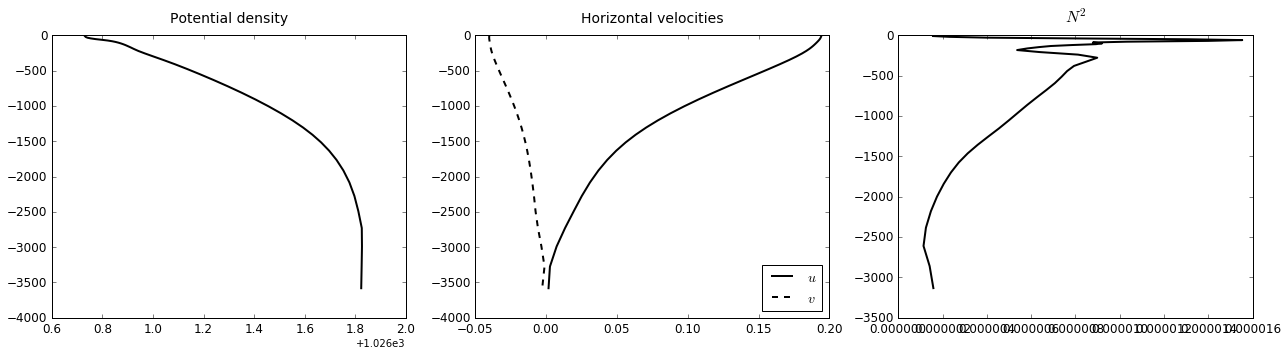

In [283]:
fig = plt.figure(figsize=(18,5))

ax1 = fig.add_subplot(131)
ax1.plot(potrho_ACC.values, -z_t.values, 'k', lw=2)
ax1.set_title('Potential density', fontsize=14, y=1.03)
# ax1.set_xlabel('lon', fontsize=12)
# ax1.set_ylabel('lat', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax2 = fig.add_subplot(132)
ax2.plot(u_ACC.values, -z_t.values, 'k', lw=2, label=r'$u$')
ax2.plot(v_ACC.values, -z_t.values, 'k--', lw=2, label=r'$v$')
ax2.set_title('Horizontal velocities', fontsize=14, y=1.03)
# ax2.set_xlabel('lon', fontsize=12)
# ax2.set_ylabel('lat',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=14)

ax3 = fig.add_subplot(133)
ax3.plot(N2_ACC.values, zN2_ACC.values, 'k', lw=2)
ax3.set_title(r'$N^2$', fontsize=16, y=1.03)
# ax1.set_xlabel('lon', fontsize=12)
# ax1.set_ylabel('lat', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

In [284]:
zphi_ACC, Rd_ACC, vd_ACC = baroclinic.neutral_modes_from_N2_profile(-zN2_ACC.values, 
                                                        N2_ACC.values, f0_meta.sel(Latitude_t=ACC[1]).values)

In [105]:
np.savez('OCCA_ACC',
        absolute_salinity=absS, conservative_temperature=consT,
        potential_density=potrho_meta, 
        z_N2=zN2_meta, N2=N2_meta,
        u_at_Tpoints=u_coinT, v_at_Tpoints=v_coinT
        )

[  1.17168641e+10   1.69315889e+04   8.10726398e+03   5.46072551e+03
   4.12684437e+03   3.33765244e+03] (43,) [-0.15249857 -0.15249857 -0.15249857 -0.15249857 -0.15249857 -0.15249857
 -0.15249857 -0.15249857 -0.15249857 -0.15249857 -0.15249857 -0.15249857
 -0.15249857 -0.15249857 -0.15249857 -0.15249857 -0.15249857 -0.15249857
 -0.15249857 -0.15249857 -0.15249857 -0.15249857 -0.15249857 -0.15249857
 -0.15249857 -0.15249857 -0.15249857 -0.15249857 -0.15249857 -0.15249857
 -0.15249857 -0.15249857 -0.15249857 -0.15249857 -0.15249857 -0.15249857
 -0.15249857 -0.15249857 -0.15249857 -0.15249857 -0.15249857 -0.15249857
 -0.15249857] [-0.20297535 -0.20296258 -0.20293747 -0.20287247 -0.20269389 -0.2023377
 -0.20183172 -0.20129993 -0.20085134 -0.20041873 -0.19990649 -0.19933816
 -0.19875064 -0.19811616 -0.19736217 -0.19642936 -0.19523347 -0.19321755
 -0.18958983 -0.18394816 -0.17658882 -0.16736786 -0.15582094 -0.14174616
 -0.12531485 -0.107045   -0.08759488 -0.06763174 -0.04776133 -0.02856812


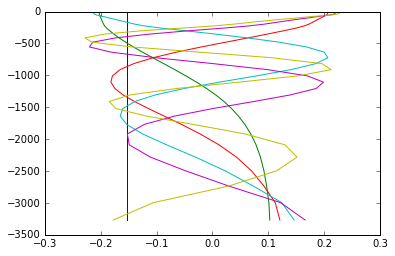

In [106]:
print Rd_ACC, zphi.shape, vd[:, 0], vd[:, 1]
plt.figure()
for i in range(vd.shape[1]):
    plt.plot(vd[:, i], -zphi)

In [285]:
dx_ACC = gsw.earth.distance([ACC[0]-.5,ACC[0]+.5], [ACC[1],ACC[1]])[0][0]
dy_ACC = gsw.earth.distance([ACC[0],ACC[0]], [ACC[1]-.5,ACC[1]+.5])[0][0]
# dx = 4e3; dy = 4e3
Nx_ACC = 100
Ny_ACC = 100
k = 2*np.pi*fft.fftshift( fft.fftfreq(Nx_ACC, dx_ACC/2e1) )
l = 2*np.pi*fft.fftshift( fft.fftfreq(Ny_ACC, dx_ACC/2e1) )

k_ACC = k[np.absolute(k) < 5.*Rd_ACC[1]**-1]
l_ACC = l[np.absolute(l) < 5.*Rd_ACC[1]**-1]

In [108]:
print dx_ACC
print k_ACC, 5.*Rd_ACC[1]**-1
print k_ACC.shape

69219.9312463
[ -2.90468260e-04  -2.72313994e-04  -2.54159727e-04  -2.36005461e-04
  -2.17851195e-04  -1.99696929e-04  -1.81542662e-04  -1.63388396e-04
  -1.45234130e-04  -1.27079864e-04  -1.08925597e-04  -9.07713312e-05
  -7.26170650e-05  -5.44627987e-05  -3.63085325e-05  -1.81542662e-05
   0.00000000e+00   1.81542662e-05   3.63085325e-05   5.44627987e-05
   7.26170650e-05   9.07713312e-05   1.08925597e-04   1.27079864e-04
   1.45234130e-04   1.63388396e-04   1.81542662e-04   1.99696929e-04
   2.17851195e-04   2.36005461e-04   2.54159727e-04   2.72313994e-04
   2.90468260e-04] 0.00029530601258
(33,)


#### w/out lateral viscosity ($A_h=0$)

In [293]:
print N2_ACC.values, u_ACC.values

[  1.56614633e-06   2.30960472e-06   3.98741745e-06   8.21571101e-06
   1.31131955e-05   1.55280899e-05   1.39889808e-05   1.03105396e-05
   8.78520858e-06   9.20224599e-06   8.92227392e-06   7.83525025e-06
   6.88891538e-06   6.34761928e-06   5.82452781e-06   5.36528898e-06
   6.39259837e-06   8.11200851e-06   8.98218708e-06   8.50278153e-06
   7.93200188e-06   7.62224820e-06   7.37058374e-06   7.06784160e-06
   6.68425393e-06   6.25867045e-06   5.82683348e-06   5.40657685e-06
   4.98165505e-06   4.53704615e-06   4.05813931e-06   3.58149852e-06
   3.13380111e-06   2.73099689e-06   2.37669931e-06   2.05310184e-06
   1.74647844e-06   1.47116548e-06   1.24720196e-06   1.13847531e-06
   1.41499174e-06   1.58314400e-06              nan              nan
              nan              nan              nan              nan
              nan] [ 0.19442396  0.19423752  0.19404019  0.19381764  0.19354731  0.19321709
  0.19282721  0.19239021  0.19192699  0.19144385  0.19093698  0.19039882
  0.189

In [296]:
zpsi_ACC0, w_ACC0, psi_ACC0 = baroclinic.instability_analysis_from_N2_profile( -zN2_ACC.values, 
                                                                   N2_ACC.values, f0_meta.sel(Latitude_t=ACC[1]).values,
                                                                   beta_meta.sel(Latitude_t=ACC[1]).values,
                                                                   k_ACC, l_ACC, z_t.values, u_ACC.values, v_ACC.values, etax, etay,
                                                                   Ah=0., num=2 )

/home/takaya/oceanmodes/oceanmodes/baroclinic.py:377: UserWarning: N2 is shorter than horizontal velocities by more than one element
  # make sure z is increasing


In [297]:
print zpsi_ACC0.shape, psi_ACC0.shape

(44,) (43, 2, 33, 33)


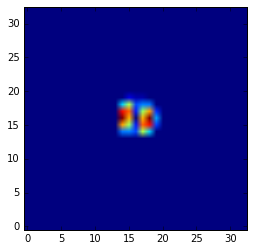

In [298]:
sig = w_ACC0[0].copy()
for i in range(14):
    sig[:, i] = np.nan
for j in range(14):
    sig[j, :] = np.nan

for i in range(-1,-14,-1):
    sig[:, i] = np.nan
for j in range(-1,-14,-1):
    sig[j, :] = np.nan

plt.imshow(sig.imag, origin='bottom')

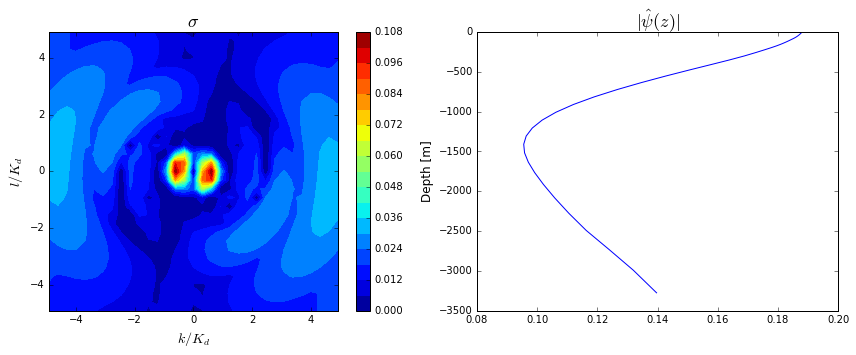

In [300]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121)
cax = ax1.contourf(k_ACC*Rd_ACC[1], l_ACC*Rd_ACC[1], w_ACC0.imag[0]*24*3600, 20)
cbar = fig.colorbar(cax, orientation='vertical')
ax1.set_xlabel(r'$k/K_d$', fontsize=14)
ax1.set_ylabel(r'$l/K_d$', fontsize=14)
ax1.set_title(r'$\sigma$', fontsize=18)

ax2 = fig.add_subplot(122)
ax2.plot(np.reshape(np.absolute(psi_ACC0[:, 0]), 
                    (psi_ACC0.shape[0], psi_ACC0.shape[-1]**2))[:, np.nanargmax(w_ACC0.imag[0])], -zpsi_ACC0[:-1])
ax2.set_ylabel(r'Depth [m]', fontsize=12)
ax2.set_title(r'$|\hat{\psi}(z)|$', fontsize=18)

plt.tight_layout()

#### w/ lateral viscosity ($A_h=10$)

In [301]:
zpsi_ACC10, w_ACC10, psi_ACC10 = baroclinic.instability_analysis_from_N2_profile( -zN2_ACC.values, 
                                                                   N2_ACC.values, f0_meta.sel(Latitude_t=ACC[1]).values,
                                                                   beta_meta.sel(Latitude_t=ACC[1]).values,
                                                                   k_ACC, l_ACC, z_t.values, u_ACC.values, v_ACC.values, etax, etay,
                                                                   Ah=1e1, num=2 )

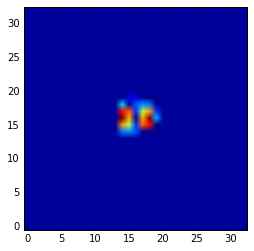

In [302]:
sig = w_ACC10[0].copy()
for i in range(14):
    sig[:, i] = np.nan
for j in range(14):
    sig[j, :] = np.nan

for i in range(-1,-14,-1):
    sig[:, i] = np.nan
for j in range(-1,-14,-1):
    sig[j, :] = np.nan

plt.imshow(sig.imag, origin='bottom')

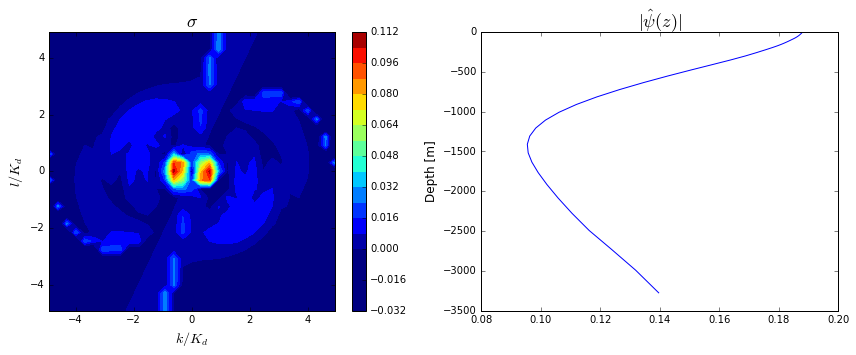

In [305]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121)
cax = ax1.contourf(k_ACC*Rd_ACC[1], l_ACC*Rd_ACC[1], w_ACC10.imag[0]*24*3600, 20, vmin=0.)
cbar = fig.colorbar(cax, orientation='vertical')
ax1.set_xlabel(r'$k/K_d$', fontsize=14)
ax1.set_ylabel(r'$l/K_d$', fontsize=14)
ax1.set_title(r'$\sigma$', fontsize=18)

ax2 = fig.add_subplot(122)
ax2.plot(np.reshape(np.absolute(psi_ACC10[:, 0]), 
                    (psi_ACC10.shape[0], psi_ACC10.shape[-1]**2))[:, np.nanargmax(w_ACC10.imag[0])], -zpsi_ACC10[:-1])
ax2.set_ylabel(r'Depth [m]', fontsize=12)
ax2.set_title(r'$|\hat{\psi}(z)|$', fontsize=18)

plt.tight_layout()